In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import pandas as pd
import openflash
print(type(openflash))
print(openflash.__path__)
print(openflash.__file__)


# --- Import core modules from package ---
try:
    from openflash import *
    from openflash.multi_constants import g
    print("OpenFLASH modules imported successfully!")
except ImportError as e:
    print(f"Error importing OpenFLASH modules. Error: {e}")

# Set NumPy print options for better readability
np.set_printoptions(threshold=np.inf, linewidth=np.inf, precision=8, suppress=True)
from openflash.multi_constants import rho #need for BEM

import time
from capytaine_generator import CapytaineSlantSolver
import capytaine as cpt
import sys
import os

# Define the path to the directory containing the package
utils_path = r"C:\Users\15183\OpenFLASH\sea-lab-utils"

if utils_path not in sys.path:
    sys.path.append(utils_path)

# Now you can import from the folder structure
# Assuming 'pyplotutilities' is a folder inside 'sea-lab-utils'
from pyplotutilities import colors
from pyplotutilities import fonts
colors.get_colors()
print(colors.purple)
fonts.get_fonts()

<class 'module'>
['C:\\Users\\15183\\OpenFLASH\\package\\src\\openflash']
C:\Users\15183\OpenFLASH\package\src\openflash\__init__.py
OpenFLASH modules imported successfully!
#CC79A7


In [2]:
css = CapytaineSlantSolver(False, True, False, False, False)
def compute_cpt_slant(config):
  t_densities = [30, 60]
  respack = css.construct_and_solve(config["a"], config["d_in"], config["d_out"], config["heaving"], t_densities, 50, config["h"], config["omega"], config["rho"], 1)
  am, dp, f_ex = (respack[0].added_mass)["Heave"], (respack[0].radiation_damping)["Heave"], (cpt.assemble_dataset([respack[2]]))["excitation_force"][0][0][0].values
  return am, dp, f_ex

In [ ]:
def MEEM_hydro_coeffs(h,omega_sweep,d_out,a_list,NMK,heaving_list):
    # Run MEEM
    d_list = d_out # drafts [m] 

    # 1. Create SteppedBody objects
    bodies_sweep = []
    
    # # Single Body
    # body = SteppedBody(
    #     a=np.array([a_list]),
    #     d=np.array([d_list]),
    #     slant_angle= np.array([[0, 0]]),
    #     heaving=heaving_list
    # )
    # Single Body
    body = SteppedBody(
        a=np.array(a_list),
        d=np.array(d_list),
        slant_angle= np.array([0, 0]),
        heaving=heaving_list
    )
    bodies_sweep.append(body)
    

    # 2. Create arrangement
    arrangement_sweep = ConcentricBodyGroup(bodies_sweep)

    # 3. Create geometry
    geometry_sweep = BasicRegionGeometry(
        body_arrangement=arrangement_sweep,
        h=h,
        NMK=NMK
    )

    # 4. Create the MEEMProblem instance
    problem_sweep = MEEMProblem(geometry_sweep)

    # 5. Set the frequencies for the sweep
    problem_sweep.set_frequencies(omega_sweep)

    # 6. Initialize a new MEEM Engine for this problem
    engine_sweep = MEEMEngine(problem_list=[problem_sweep])

    # --- 3.2. Run the Full Sweep ---
    results_obj_sweep = engine_sweep.run_and_store_results(problem_index=0)

    # Get the xarray.Dataset
    ds_sweep = results_obj_sweep.get_results()

    # Extract the Added Mass and Damping matrices.
    # These are 3D arrays: (frequency, mode_j, mode_i)
    # A[freq, 1, 0] = Added Mass on body 1 due to motion of body 0
    A_MEEM = ds_sweep.added_mass.values
    B_MEEM = ds_sweep.damping.values
    return A_MEEM, B_MEEM

def BEM_hydro_coeffs(h,rho,omega_sweep,d_in,d_out,a_list):
    # Run BEM
    heaving_list = [1, 1]
    A_BEM = np.zeros_like(omega_sweep)
    B_BEM = np.zeros_like(omega_sweep)
    F_ex_BEM = np.zeros(len(omega_sweep), dtype=np.complex128)

    for j in range(len(omega_sweep)):
        
        print(j)
        i=1
        omega = omega_sweep[j]
        config = {"name" : "config-(" + str(i) + ")",
                    "h" : h,
                    "a" : a_list,
                    "d_in" : d_in,
                    "d_out" : d_out,
                    "heaving": heaving_list,
                    "NMK" : [100, 100], #this is unused
                    "omega" : omega,
                    "rho" : rho}
        Capy_results = compute_cpt_slant(config)
        A_BEM[j] = Capy_results[0]
        B_BEM[j] = Capy_results[1]
        F_ex_BEM[j] = Capy_results[2]
    return A_BEM, B_BEM

In [4]:
# Run 1: Non-slanted CorPower WEC

h = 50.00 # sea depth [m]
omega_sweep = np.linspace(0.4, 1.5, 10) # rad/s
d_in = [14.45, 14.45-7.32-5.08] # drafts [m]
d_out = d_in # non-slanted version
a_list = [2.5/2, 8.4/2] # radii [m]
NMK = [100, 100, 100] # number of coefficients in each region
heaving_list = True 

In [ ]:
A_MEEM, B_MEEM = MEEM_hydro_coeffs(h,omega_sweep,d_out,a_list,NMK,heaving_list)
A_BEM, B_BEM = BEM_hydro_coeffs(h,rho,omega_sweep,d_in,d_out,a_list)


Hydrodynamic coefficients stored in xarray dataset.
Potentials stored in xarray dataset (batched across frequencies/modes).
0
Panel Count:  1920
1
Panel Count:  1920
2
Panel Count:  1920
3
Panel Count:  1920
4
Panel Count:  1920
5
Panel Count:  1920
6
Panel Count:  1920
7
Panel Count:  1920
8
Panel Count:  1920
9
Panel Count:  1920


In [6]:
# Plot Settings
l_width = 3 # line width
m_size = 7 # marker size
lab_fs = 18 # x and y label font size
leg_fs = lab_fs * 0.85 # legend font size
fig_h = 6 # figure height
fig_w = 5 # figure width



In [25]:
# Set limits of plots
x_max_lim = 1.05*np.max(omega_sweep)
x_min_lim = np.min(omega_sweep) - 0.05*np.max(omega_sweep)

A_max_lim = 1.15*np.max([A_MEEM.squeeze(),A_BEM.squeeze()])
B_max_lim = 1.05*np.max([B_MEEM.squeeze(),B_BEM.squeeze()])

x_scale = x_max_lim-x_min_lim
y_scale = A_max_lim

max_y_val = A_max_lim
frac_of_plot = 0.3
x_shift_scale = 0.9
y_shift_scale = 0.97

xy_translation = [x_scale*x_shift_scale + x_min_lim, max_y_val*y_shift_scale]

In [26]:
# Function for getting coordinates of WEC geometry
def get_scaled_geom(a_list, d_in, d_out, frac_of_plot, xy_translation, x_scale, y_scale):
    normalization_factor = np.max([a_list, d_in, d_out]) 

    RHS_coords = css.get_points(a_list, d_in, d_out)
    x_coords, y_coords = map(np.array, zip(*RHS_coords))

    x_undeformed = np.concatenate([-x_coords[::-1], x_coords])
    y_undeformed = np.concatenate([y_coords[::-1], y_coords])

    x_deformed = frac_of_plot*(x_scale/normalization_factor) * x_undeformed + xy_translation[0]
    y_deformed = frac_of_plot*(y_scale/normalization_factor)* y_undeformed + xy_translation[1]
    return x_undeformed, y_undeformed, x_deformed, y_deformed


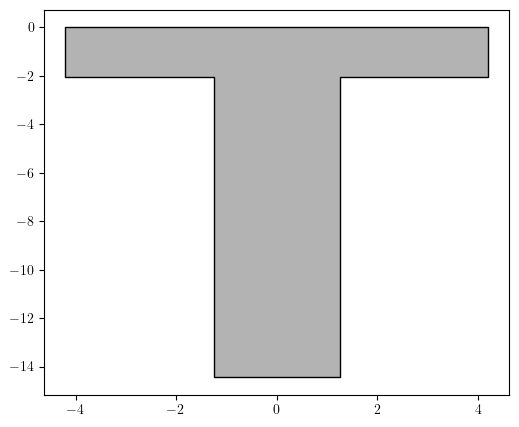

In [ ]:
x_undeformed, y_undeformed, x_deformed, y_deformed = get_scaled_geom(a_list, d_in, d_out, frac_of_plot, xy_translation, x_scale, y_scale)

fig, ax = plt.subplots(figsize=(fig_h, fig_w))
ax.fill(x_undeformed, y_undeformed, color=[0.7,0.7,0.7], edgecolor='black')

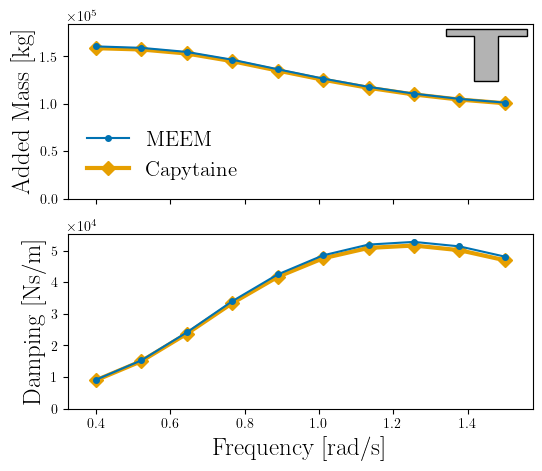

In [29]:
fig, ax = plt.subplots(2, 1, figsize=(fig_h, fig_w), sharex=True)
for a in ax:
    formatter = ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-1, 1)) 
    a.yaxis.set_major_formatter(formatter)

ax[0].plot(omega_sweep, 
           A_MEEM.squeeze(),
           marker='o', 
           linestyle='-', 
           color=colors.blue, 
           label='MEEM', 
           linewidth=l_width-1.5,
           markersize=m_size-3,
           zorder=2)
ax[0].plot(omega_sweep, 
           A_BEM.squeeze(), 
           marker='D',
           linestyle='-', 
           color=colors.orange, 
           label='Capytaine', 
           linewidth=l_width,
           markersize=m_size,
           zorder=1)

ax[0].fill(x_deformed, y_deformed, color=[0.7,0.7,0.7], edgecolor='black')

ax[0].set_ylim([0, A_max_lim])
ax[0].set_xlim([x_min_lim, x_max_lim])
# ax[0].set_xlabel('Frequency [rad/s]', fontsize=lab_fs)
ax[0].set_ylabel('Added Mass [kg]', fontsize=lab_fs)
ax[0].legend(loc='lower left', fontsize=leg_fs, frameon=False)


ax[1].plot(omega_sweep, 
           B_MEEM.squeeze(),
           marker='o', 
           linestyle='-', 
           color=colors.blue, 
           label='MEEM', 
           linewidth=l_width-1.5,
           markersize=m_size-3,
           zorder=2)
ax[1].plot(omega_sweep, 
           B_BEM.squeeze(), 
           marker='D',
           linestyle='-', 
           color=colors.orange, 
           label='Capytaine', 
           linewidth=l_width,
           markersize=m_size,
           zorder=1)
ax[1].set_ylim([0, B_max_lim])
ax[1].set_xlim([x_min_lim, x_max_lim])
ax[1].set_xlabel('Frequency [rad/s]', fontsize=lab_fs)
ax[1].set_ylabel('Damping [Ns/m]', fontsize=lab_fs)
full_path = r"C:\Users\15183\OpenFLASH\pubs\JFM\figs\MEEM_vs_Capytaine_Nonslant_Validation.pdf"
fig.savefig(full_path, format='pdf', dpi=300, bbox_inches='tight')

In [16]:
A_error = 100 * np.mean(np.abs((A_MEEM.squeeze()-A_BEM.squeeze())/A_BEM.squeeze()))
B_error = 100 * np.mean(np.abs((B_MEEM.squeeze()-B_BEM.squeeze())/B_BEM.squeeze()))
print('Added mass is ' + str(A_error)+ ' percent off')
print('Damping is ' + str(B_error) + ' percent off')

Added mass is 0.9348808903228556 percent off
Damping is 2.002802629088475 percent off


In [30]:
# Run 2: Slanted CorPower WEC

h = 50.00 # sea depth [m]
omega_sweep = np.linspace(0.4, 1.5, 10) # rad/s
d_in = [14.45, 14.45-7.32] # drafts [m]
d_out = [14.45, 14.45-7.32-5.08] # non-slanted version
a_list = [2.5/2, 8.4/2] # radii [m]
NMK = [100, 100, 100] # number of coefficients in each region
heaving_list = True 

In [37]:
A_MEEM, B_MEEM = MEEM_hydro_coeffs(h,omega_sweep,d_out,a_list,NMK,heaving_list) #swap function for Bimali's MEEM slant approx code
A_MEEM_corrected, B_MEEM_corrected = 0.7*A_MEEM, 0.7*B_MEEM #swap function for Bimali's MEEM slant approx code (w/ correction)
A_BEM, B_BEM = BEM_hydro_coeffs(h,rho,omega_sweep,d_in,d_out,a_list)

Hydrodynamic coefficients stored in xarray dataset.
Potentials stored in xarray dataset (batched across frequencies/modes).
0
Panel Count:  2220
1
Panel Count:  2220
2
Panel Count:  2220
3
Panel Count:  2220
4
Panel Count:  2220
5
Panel Count:  2220
6
Panel Count:  2220
7
Panel Count:  2220
8
Panel Count:  2220
9
Panel Count:  2220


In [38]:
# Set limits of plots
x_max_lim = 1.05*np.max(omega_sweep)
x_min_lim = np.min(omega_sweep) - 0.05*np.max(omega_sweep)

A_max_lim = 1.15*np.max([A_MEEM.squeeze(),A_MEEM_corrected.squeeze(),A_BEM.squeeze()])
B_max_lim = 1.05*np.max([B_MEEM.squeeze(),B_MEEM_corrected.squeeze(),B_BEM.squeeze()])

x_scale = x_max_lim-x_min_lim
y_scale = A_max_lim

max_y_val = A_max_lim
frac_of_plot = 0.3
x_shift_scale = 0.9
y_shift_scale = 0.97

xy_translation = [x_scale*x_shift_scale + x_min_lim, max_y_val*y_shift_scale]

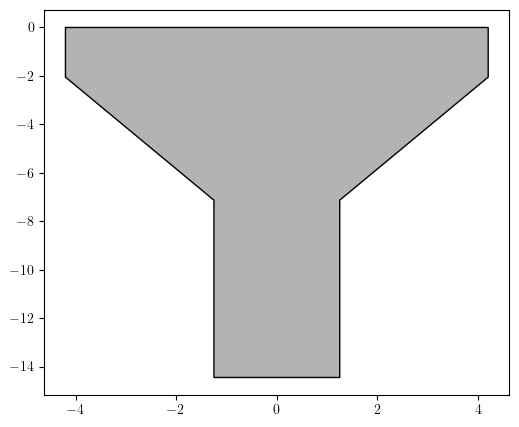

In [39]:
x_undeformed, y_undeformed, x_deformed, y_deformed = get_scaled_geom(a_list, d_in, d_out, frac_of_plot, xy_translation, x_scale, y_scale)

fig, ax = plt.subplots(figsize=(fig_h, fig_w))
ax.fill(x_undeformed, y_undeformed, color=[0.7,0.7,0.7], edgecolor='black')

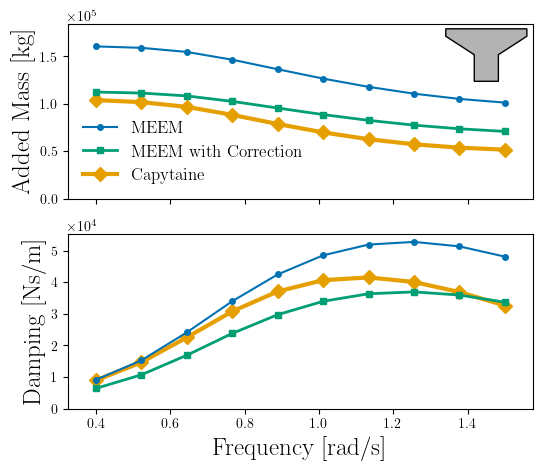

In [47]:
fig, ax = plt.subplots(2, 1, figsize=(fig_h, fig_w), sharex=True)
for a in ax:
    formatter = ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-1, 1)) 
    a.yaxis.set_major_formatter(formatter)

ax[0].plot(omega_sweep, 
           A_MEEM.squeeze(),
           marker='o', 
           linestyle='-', 
           color=colors.blue, 
           label='MEEM', 
           linewidth=l_width-1.5,
           markersize=m_size-3,
           zorder=3)
ax[0].plot(omega_sweep, 
           A_MEEM_corrected.squeeze(),
           marker='s', 
           linestyle='-', 
           color=colors.green, 
           label='MEEM with Correction', 
           linewidth=l_width-1,
           markersize=m_size-2,
           zorder=2)
ax[0].plot(omega_sweep, 
           A_BEM.squeeze(), 
           marker='D',
           linestyle='-', 
           color=colors.orange, 
           label='Capytaine', 
           linewidth=l_width,
           markersize=m_size,
           zorder=1)

ax[0].fill(x_deformed, y_deformed, color=[0.7,0.7,0.7], edgecolor='black')

ax[0].set_ylim([0, A_max_lim])
ax[0].set_xlim([x_min_lim, x_max_lim])
# ax[0].set_xlabel('Frequency [rad/s]', fontsize=lab_fs)
ax[0].set_ylabel('Added Mass [kg]', fontsize=lab_fs)
ax[0].legend(loc='lower left', fontsize=leg_fs*0.8, frameon=False)


ax[1].plot(omega_sweep, 
           B_MEEM.squeeze(),
           marker='o', 
           linestyle='-', 
           color=colors.blue, 
           label='MEEM', 
           linewidth=l_width-1.5,
           markersize=m_size-3,
           zorder=3)
ax[1].plot(omega_sweep, 
           B_MEEM_corrected.squeeze(),
           marker='s', 
           linestyle='-', 
           color=colors.green, 
           label='MEEM with Correction', 
           linewidth=l_width-1,
           markersize=m_size-2,
           zorder=2)
ax[1].plot(omega_sweep, 
           B_BEM.squeeze(), 
           marker='D',
           linestyle='-', 
           color=colors.orange, 
           label='Capytaine', 
           linewidth=l_width,
           markersize=m_size,
           zorder=1)
ax[1].set_ylim([0, B_max_lim])
ax[1].set_xlim([x_min_lim, x_max_lim])
ax[1].set_xlabel('Frequency [rad/s]', fontsize=lab_fs)
ax[1].set_ylabel('Damping [Ns/m]', fontsize=lab_fs)
full_path = r"C:\Users\15183\OpenFLASH\pubs\JFM\figs\MEEM_vs_Capytaine_Slant_Validation.pdf"
fig.savefig(full_path, format='pdf', dpi=300, bbox_inches='tight')